# 1. IMPORTS 

In [100]:
import pandas as pd
from inflection import underscore
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

## 1. 1 HELPER FUNCTIONS

In [63]:
pd.set_option('display.max_rows', 100)

## 1.2 LOADING DATA

In [64]:
df_store = pd.read_csv('./datasets/store.csv', low_memory = False)
df_train = pd.read_csv('./datasets/train.csv', low_memory = False)
df_raw = df_store.merge(df_train, how='left', on='Store')

# 2. DATA DESCRIPTION 

## 2.1 RENAME COLUMNS

In [65]:
# Trasorming columns names into snake_case
old_cols = df_raw.columns.to_list()
new_cols = [underscore(w) for w in old_cols]
df_raw.columns = new_cols

## 2.2 DATA DIMENSIONS

In [66]:
print(f'Dataset has {df_raw.shape[0]} lines and {df_raw.shape[1]} columns')

Dataset has 1017209 lines and 18 columns


## 2.3 CHECK DTYPES

In [67]:
df_raw.dtypes

store                             int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
dtype: object

## 2.4 CHECK NA

In [68]:
df_raw.isna().sum()

store                                0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
dtype: int64

## 2.5 FILL NA VALUES

In [69]:
#Para não dar erro é preciso converter a coluna 'date' para datetime antes de preencher os valores NA.
df_raw['date'] = pd.to_datetime( df_raw['date'] ) 

In [70]:
# competition_distance ( vamos trocar os NA's por uma distnacia muito grande, presumindo que não exista competição próxima)
df_raw['competition_distance'] = df_raw['competition_distance'].apply(lambda x: 20000 if pd.isna( x ) else x).astype('int64')

# competition_open_since_month ( qunando for NA vamos substituir pelo mês da data atual)
df_raw['competition_open_since_month']  = df_raw.apply(lambda x: x['date'].month if pd.isna( x['competition_open_since_month'] )  else x['competition_open_since_month'], axis = 1)

# competition_open_since_year
df_raw['competition_open_since_year']  = df_raw.apply(lambda x: x['date'].year if pd.isna( x['competition_open_since_year'] )  else x['competition_open_since_year'], axis = 1)

# promo2_since_week
df_raw['promo2_since_week'] = df_raw.apply(lambda x: x['date'].week if pd.isna( x['promo2_since_week']) else x['promo2_since_week'], axis = 1)

# promo2_since_year
df_raw['promo2_since_year'] = df_raw.apply(lambda x: x['date'].year if pd.isna(x['promo2_since_year']) else x['promo2_since_year' ], axis = 1) 

# promo_interval
month_map = {1: 'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df_raw['promo_interval'].fillna(0, inplace=True)
df_raw['month_map'] = df_raw['date'].dt.month.map( month_map )
df_raw['is_promo'] = df_raw.apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if str( x['month_map'] ) in str( x['promo_interval']) else 0, axis=1)

## 2.6 CHANGE DTYPES

In [71]:
# Transforming 'date' columns into datetime
df_raw['date'] = pd.to_datetime( df_raw['date'] )

# competition_open_since_month into int
df_raw['competition_open_since_month'] = df_raw['competition_open_since_month'].astype( 'int64' )

# competition_open_since_year into int
df_raw['competition_open_since_year']  = df_raw['competition_open_since_year'].astype( 'int64' )

# promo2_since_week into int
df_raw['promo2_since_week'] = df_raw['promo2_since_week'].astype( 'int64' )

# promo2_since_year into int
df_raw['promo2_since_year'] = df_raw['promo2_since_year'].astype( 'int64' )

## 2.7 DESCRIPTIVE STATISTICS

In [72]:
num_attributes = df_raw.select_dtypes( include = ['int64', 'float64'])
cat_attributes = df_raw.select_dtypes( exclude = ['int64', 'float64', 'datetime64[ns]'])

In [73]:
num_attributes.describe()

,store,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,day_of_week,sales,customers,open,promo,school_holiday,is_promo
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,5.467928e+03,6.786849e+00,2.010325e+03,5.005638e-01,2.361903e+01,2.012793e+03,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01,1.718349e-01
std,3.219087e+02,7.740901e+03,3.311087e+00,5.515593e+00,4.999999e-01,1.431006e+01,1.662658e+00,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01,3.772371e-01
min,1.000000e+00,2.000000e+01,1.000000e+00,1.900000e+03,0.000000e+00,1.000000e+00,2.009000e+03,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,7.100000e+02,4.000000e+00,2.008000e+03,0.000000e+00,1.200000e+01,2.012000e+03,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,2.330000e+03,7.000000e+00,2.012000e+03,1.000000e+00,2.200000e+01,2.013000e+03,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.910000e+03,1.000000e+01,2.014000e+03,1.000000e+00,3.700000e+01,2.014000e+03,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
max,1.115000e+03,7.586000e+04,1.200000e+01,2.015000e+03,1.000000e+00,5.200000e+01,2.015000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [74]:
# Central Tendency
mean   = pd.DataFrame( num_attributes.apply( np.mean ) ).T
median = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis,
std      = pd.DataFrame( num_attributes.apply( np.std ) ).T
minimum  = pd.DataFrame( num_attributes.apply( min ) ).T
maximum  = pd.DataFrame( num_attributes.apply( max ) ).T
range_   = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
skew     = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
kurtosis = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

metrics = pd.concat( [mean, median, std, minimum, maximum, range_, skew, kurtosis] ).T.reset_index()

In [75]:
metrics

,index,0,0,0,0,0,0,0,0
0,store,558.429727,558.0,321.908493,1.0,1115.0,1114.0,-0.000955,-1.200524
1,competition_distance,5467.928135,2330.0,7740.896804,20.0,75860.0,75840.0,2.894723,12.724442
2,competition_open_since_month,6.786849,7.0,3.311085,1.0,12.0,11.0,-0.042076,-1.232607
3,competition_open_since_year,2010.324840,2012.0,5.515591,1900.0,2015.0,115.0,-7.235657,124.071304
4,promo2,0.500564,1.0,0.500000,0.0,1.0,1.0,-0.002255,-1.999999
5,promo2_since_week,23.619033,22.0,14.310057,1.0,52.0,51.0,0.178723,-1.184046
6,promo2_since_year,2012.793297,2013.0,1.662657,2009.0,2015.0,6.0,-0.784436,-0.210075
7,day_of_week,3.998341,4.0,1.997390,1.0,7.0,6.0,0.001593,-1.246873
8,sales,5773.818972,5744.0,3849.924283,0.0,41551.0,41551.0,0.641460,1.778375
9,customers,633.145946,609.0,464.411506,0.0,7388.0,7388.0,1.598650,7.091773


In [76]:
metrics.columns = ['column', 'mean', 'median', 'std', 'min', 'max', 'range', 'skew', 'kurtosis']

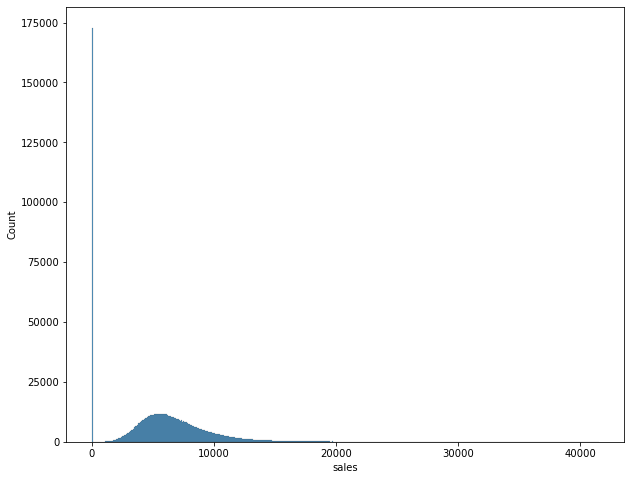

In [77]:
plt.figure( figsize = ( 10, 8 ) )
sns.histplot( data=df_raw['sales'] );

In [78]:
cat_attributes.head()

,store_type,assortment,promo_interval,state_holiday,month_map
0,c,a,0,0,Jul
1,c,a,0,0,Jul
2,c,a,0,0,Jul
3,c,a,0,0,Jul
4,c,a,0,0,Jul


''

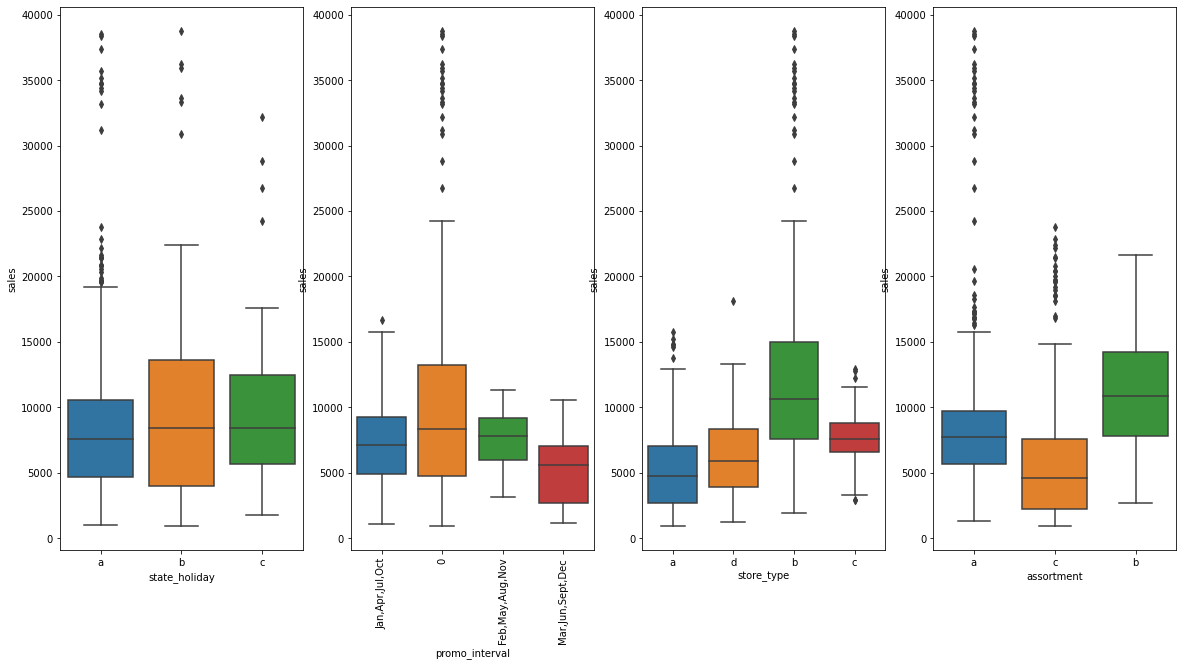

In [79]:
plt.figure(figsize=(20, 10))
plt.GridSpec(1, 2)

plt.subplot(1, 4, 1)
aux1 = df_raw[(df_raw['sales'] > 0) & (df_raw['state_holiday'] != '0')]
sns.boxplot (data=aux1, x='state_holiday', y='sales' )

plt.subplot(1, 4, 2)
aux2 = df_raw[(df_raw['sales'] > 0) & (df_raw['promo_interval'] != 0)]
sns.boxplot(data=aux1, x='promo_interval', y='sales')
plt.xticks(rotation=90)

plt.subplot(1, 4, 3)
aux3 = df_raw[(df_raw['sales'] > 0) & (df_raw['store_type'] != '0')]
sns.boxplot(data=aux1, x='store_type', y='sales')

plt.subplot(1, 4, 4)
aux4 = df_raw[(df_raw['sales'] > 0) & (df_raw['assortment'] != '0')]
sns.boxplot(data=aux1, x='assortment', y='sales')


;

# 3. FEATURE ENGINEERING 

## 3.1 HIPÓTESES A SEREM TESTADAS

1. Lojas com maior sortimento deveriam vender mais
2. Lojas com competidores mais próximos deveriam vender menos
3. Lojas com competidores à mais tempo vendem mais.
4. Lojas com promoções ativas por mais tempo deveriam vender mais
5. Lojas com mais dias de promoção deveriam vender mais.
6. Lojas com mais promoções consecutivas deveriam vender mais.
7. Lojas abertas durante o feriado de Natal deveriam vender mais.
8. Lojas deveriam vender mais ao longo dos anos
9. Lojas deveriam vender mais no segundo semestre do ano.
10. Lojas deveriam vender mais depois do dia 10 de cada mês.
11. Lojas deveriam vender menos aos finais de semana
12. Lojas deveriam vender menos durante os feriados escolares.

In [80]:
df1 = df_raw.copy()

## 3.2 FEATURE ENGINEERING

In [81]:
df1['date'].head()

0   2015-07-31
1   2015-07-30
2   2015-07-29
3   2015-07-28
4   2015-07-27
Name: date, dtype: datetime64[ns]

In [94]:
df1.dtypes

store                                    int64
store_type                              object
assortment                              object
competition_distance                     int64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
month_map                               object
is_promo                                 int64
year                                     int64
month        

In [102]:
#year
df1['year'] = df1['date'].dt.year

# month
df1['month'] = df1['date'].dt.month

# week of year
df1['week'] = df1['date'].dt.isocalendar().week

#year week
df1['year_week'] = df1['date'].dt.strftime( '%Y-%W')

# competition_since
df1['competition_since'] = df1.apply(lambda x: datetime(year = x['competition_open_since_year'], month = x['competition_open_since_month'], day=1), axis = 1)
df1['competition_time_month'] =  ((df1['date'] - df1['competition_since'] ) / 30 ).apply(lambda x: x.days).astype( int )

# promo since
df1['promo_since'] = df1['promo2_since_year'].astype( str ) + '-' + df1['promo2_since_week'].astype( str )
df1['promo_since'] = df1['promo_since'].apply( lambda x: datetime.strptime(x + '-1', '%Y-%W-%w') - timedelta(days=7))
df1['promo_time_week'] = ( ( df1['date'] - df1['promo_since'] ) / 7 ).apply( lambda x: x.days ).astype( int )

# assortment describes an assortment level: a = basic, b = extra, c = extended
df1['assortment'] = df1['assortment'].apply (lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

#state holiday a = public holiday, b = Easter holiday, c = Christmas, 0 = None
df1['state_holiday'] = df1['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'chistmas' if x == 'c' else 'regular_day')

# 4. FILTRAGEM DAS VARIÁVEIS

In [104]:
df2 = df1.copy()

## 4.1 FILTRAGEM DAS LINHAS

In [111]:
df2 = df2[( df2['open'] != 0) & (df2['sales'] > 0) ]

## 4.2 SELEÇÃO DAS COLUNAS

In [113]:
df2.drop(columns=['customers','open', 'month_map', 'promo_interval'], inplace=True)